In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
import numpy as np
import sys
import pandas as pd
import os
sys.path.append("../")
import utils.common
import seaborn as sns
import matplotlib.pyplot as plt
import logging
import utils.exp_pong_multi_ball
from utils.common import get_trial_paths, get_trial_df, get_initial_state_df, get_prey_pos_df, display_prey_agent_pos, get_agent_pos_df, get_occluders_pos_df

logger = logging.getLogger()
logger.setLevel(logging.ERROR)
logger.info('DEBUG')

In [20]:
human_base_path = '../../logs/exp_pong_multi_ball/1'
trial_paths = get_trial_paths(human_base_path)
trial_df = get_trial_df(trial_paths)
trial_df = (trial_df.pipe(get_initial_state_df)
    .pipe(utils.exp_pong_multi_ball.get_condition_df)
    .drop('initial_state', axis='columns')  
    .pipe(get_agent_pos_df)
    .pipe(get_occluders_pos_df)  
    .pipe(utils.common.get_states_df)
    .assign(prey_pos=utils.common.get_prey_pos_from_states)
    # finding sorted indices of prey according to y position
    .assign(prey_ix=lambda df: [np.argsort(prey_y) for prey_y in df.prey_y], axis=1)
    # sorting x coordinates 
    .assign(prey_x=lambda df: [np.array(prey_x)[prey_ix] for (prey_x, prey_ix) in zip(df.prey_x, df.prey_ix)]) 
    # sorting y coordinates       
    .assign(prey_y=lambda df: [np.array(prey_y)[prey_ix] for (prey_y, prey_ix) in zip(df.prey_y, df.prey_ix)])   
    # sorting position
    .assign(prey_pos=lambda df: [np.array(prey_pos)[prey_ix] for (prey_pos, prey_ix) in zip(df.prey_pos, df.prey_ix)])
    .assign(prey_end_step=utils.exp_pong_multi_ball.get_prey_end_step, 
        error=utils.exp_pong_multi_ball.get_error,
        success=utils.exp_pong_multi_ball.get_success,
        prey_visible=utils.exp_pong_multi_ball.get_prey_visible,
        prey_visible_step=utils.exp_pong_multi_ball.get_prey_visible_step)
    .drop(['states', 'occluders_pos'], axis='columns'))
trial_df = (trial_df
    .merge(pd.DataFrame(trial_df.prey_x.to_list(), columns=['prey_x_%i' % i for i in range(3)], index=trial_df.index), left_index=True, right_index=True)
    .merge(pd.DataFrame(trial_df.prey_y.to_list(), columns=['prey_y_%i' % i for i in range(3)], index=trial_df.index), left_index=True, right_index=True)
    .merge(pd.DataFrame(trial_df.error.to_list(), columns=['error_%i' % i for i in range(3)], index=trial_df.index), left_index=True, right_index=True)
    .merge(pd.DataFrame(trial_df.success.to_list(), columns=['success_%i' % i for i in range(3)], index=trial_df.index), left_index=True, right_index=True)
    .merge(pd.DataFrame(trial_df.prey_pos.to_list(), columns=['prey_pos_%i' % i for i in range(3)], index=trial_df.index), left_index=True, right_index=True)
    .set_index(['prey_x_0', 'prey_x_1', 'prey_x_2', 'prey_y_0', 'prey_y_1', 'prey_y_2', 'occluded'])
    .sort_index()
)

<ipython-input-20-ab429a9bcdac>:18: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  .assign(prey_pos=lambda df: [np.array(prey_pos)[prey_ix] for (prey_pos, prey_ix) in zip(df.prey_pos, df.prey_ix)])


# Average error per ball

In [14]:
prey_df = trial_df.reset_index().filter(['prey_x_0', 'prey_x_1', 'prey_x_2', 'prey_y_0', 'prey_y_1', 'prey_y_2', 'error_0', 'error_1', 'error_2', 'occluded', 'trial_num'])
prey_df = prey_df.set_index('trial_num').apply(pd.Series.explode).reset_index()

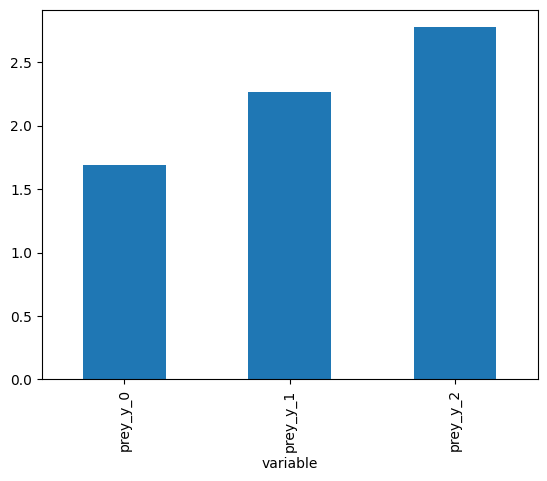

In [15]:
prey_df.melt(id_vars='trial_num', value_vars=['prey_y_0', 'prey_y_1', 'prey_y_2']).groupby('variable')['value'].mean().plot.bar()
plt.show()

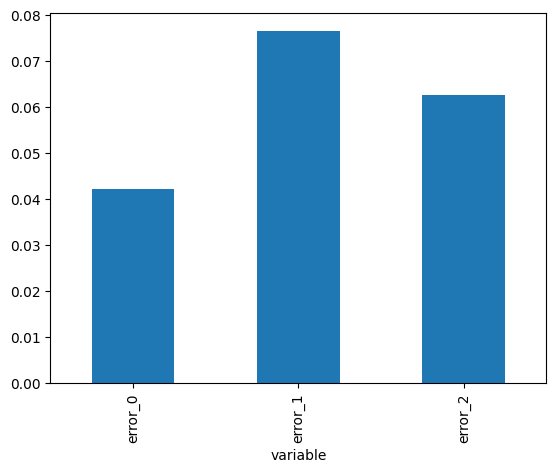

In [16]:
prey_df.melt(id_vars='trial_num', value_vars=['error_0', 'error_1', 'error_2']).groupby('variable')['value'].mean().plot.bar()
plt.show()

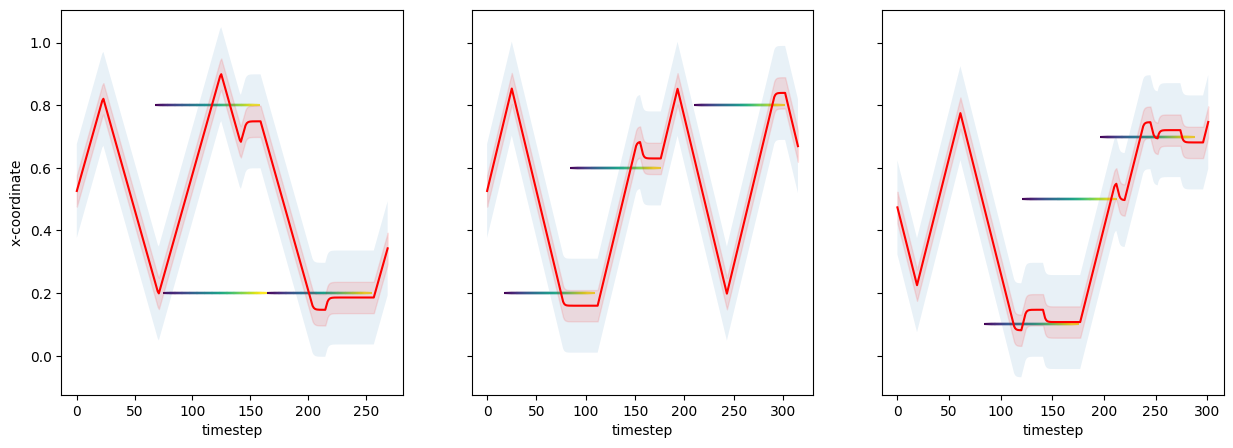

In [89]:
n_conditions = 3
conditions = np.random.choice(trial_df.loc[pd.IndexSlice[:, :, :, :, :, :, True], :].index.unique(), n_conditions, replace=False)
f, axs = plt.subplots(1, n_conditions, figsize=(15, 5), dpi=100, sharey=True)
for i_c, condition in enumerate(conditions):
    trials = trial_df.loc[condition]
    agent_pos = trials.agent_pos
    prey_pos = trials.prey_pos
    prey_visible_step = trials.prey_visible_step
    n_trials = len(trials)
    for (pvs, p)in zip(prey_visible_step, prey_pos):
        p = np.asarray(p)
        t_start = np.where(p[:, 1] <= 1.0)[0][0]
        t_end = np.where(p[:, 1] <= 0.1 + 0.05)[0][0]
        t = np.arange(t_start, t_end)
        axs[i_c].scatter(t, p[t_start:t_end, 0], label=p[0,1], c=np.linspace(0,1, num=len(t)), marker='_')                
    axs[i_c].fill_between(np.arange(len(agent_pos[:, 0])), agent_pos[:, 0]-0.15, agent_pos[:, 0]+0.15, alpha=0.1)
    axs[i_c].fill_between(np.arange(len(agent_pos[:, 0])), agent_pos[:, 0]-0.05, agent_pos[:, 0]+0.05, color='red', alpha=0.1)
    axs[i_c].plot(np.arange(len(agent_pos)), agent_pos[:, 0], c='red')
    axs[i_c].set_xlabel('timestep')
axs[0].set_ylabel('x-coordinate')
plt.show()

In [75]:
n_conditions = 5
conditions = np.random.choice(trial_df.loc[pd.IndexSlice[:, True], :].index.unique(), n_conditions, replace=False)
f, axs = plt.subplots(1, n_conditions, figsize=(10, 5), dpi=100, sharey=True)
for i_c, condition in enumerate(conditions):
    trials = trial_df.loc[condition]
    agent_pos = trials.agent_pos.to_numpy()
    trial_end_step = trials.trial_end_step.to_numpy()
    success = trials.success.to_numpy()
    prey_pos = trials.prey_pos.to_numpy()
    visibility_step = trials.prey_visible_step.to_numpy()
    n_trials = len(trials)
    
    for i, (ap, vs, s, pp) in enumerate(list(zip(agent_pos, visibility_step, success, prey_pos))):
        ap = np.asarray(ap).squeeze()[:, 0]
        pp = np.asarray(pp).squeeze()[:, 0]
        vap = ap[vs:] if vs != -1 else []
        oap = ap[:vs]
        ot = np.arange(vs) if vs != -1 else np.arange(len(ap)-1)        
        vt = np.arange(start=vs, stop=len(ap), step=1) if vs != -1 else []        
        linestyle = '-' if s else '--'                
        color = 'b' if s else 'r'
        axs[i_c].plot(ot, oap, color='r', linestyle=linestyle, alpha=0.5)    
        axs[i_c].plot(vt, vap, color='b', linestyle=linestyle, alpha=0.5)
        axs[i_c].plot(np.arange(len(ap)), ap, linestyle='--', alpha=0.3, color='k')
        axs[i_c].set_xlabel('timestep')
    axs[0].set_ylabel('x-position')        
    axs[i_c].plot(np.arange(len(ap)), pp,  alpha=0.7, color='g')    
plt.tight_layout()
plt.show()

KeyError: True

In [83]:
sns.lineplot(x='prey_x', y='error', hue='occluded', data=trial_df.reset_index())
plt.show()

ValueError: Could not interpret value `prey_x` for parameter `x`

In [84]:
n_conditions = 5
conditions = np.random.choice(trial_df.loc[pd.IndexSlice[:, True], :].index.unique(), n_conditions, replace=False)
f, axs = plt.subplots(1, n_conditions, figsize=(10, 5), dpi=100, sharey=True)
for i_c, condition in enumerate(conditions):
    trials = trial_df.loc[condition].sample(5, replace=False)
    agent_vel = trials.agent_vel.to_numpy()
    success = trials.success.to_numpy()
    for i, (av, vs, s) in enumerate(list(zip(agent_vel, visibility_step, success))):
        if vs != -1:
            av = av[:vs]                
            avt = np.linspace(-vs, 0, num=vs)
            linestyle = '-' if s else '--'                            
            axs[i_c].plot(avt, av, linestyle=linestyle, alpha=0.5)                                         
plt.tight_layout()
plt.show()

TypeError: unhashable type: 'slice'